In [35]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import load_md_from_file

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

PATH_TO_FILE = '/Users/ilyalobanov/CMF HFT/HW3/simulator/Data2/lobs.csv'
NROWS = 200000

In [36]:
data = pd.read_csv('/Users/ilyalobanov/CMF HFT/HW3/simulator/Data2/lobs.csv', nrows=NROWS)
data.head()

,receive_ts,exchange_ts,btcusdt:Binance:LinearPerpetual_ask_price_0,btcusdt:Binance:LinearPerpetual_ask_vol_0,btcusdt:Binance:LinearPerpetual_bid_price_0,btcusdt:Binance:LinearPerpetual_bid_vol_0,btcusdt:Binance:LinearPerpetual_ask_price_1,btcusdt:Binance:LinearPerpetual_ask_vol_1,btcusdt:Binance:LinearPerpetual_bid_price_1,btcusdt:Binance:LinearPerpetual_bid_vol_1,...,btcusdt:Binance:LinearPerpetual_bid_price_7,btcusdt:Binance:LinearPerpetual_bid_vol_7,btcusdt:Binance:LinearPerpetual_ask_price_8,btcusdt:Binance:LinearPerpetual_ask_vol_8,btcusdt:Binance:LinearPerpetual_bid_price_8,btcusdt:Binance:LinearPerpetual_bid_vol_8,btcusdt:Binance:LinearPerpetual_ask_price_9,btcusdt:Binance:LinearPerpetual_ask_vol_9,btcusdt:Binance:LinearPerpetual_bid_price_9,btcusdt:Binance:LinearPerpetual_bid_vol_9
0,1655942402250125991,1655942402249000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19976.7,0.066,...,19975.7,4.455,19980.1,0.01,19975.6,1.529,19980.2,0.01,19975.4,1.641
1,1655942402657844605,1655942402655000000,19977.5,0.078,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455
2,1655942403346968722,1655942403346000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455
3,1655942404080791047,1655942404080000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455
4,1655942404452706766,1655942404452000000,19977.5,0.079,19977.4,12.381,19977.8,0.003,19977.3,0.126,...,19975.9,0.246,19980.1,0.01,19975.8,0.686,19980.2,0.01,19975.7,4.455


In [38]:
data['receive_ts'] = pd.to_datetime(data['receive_ts'])

In [40]:
data.columns = [i.replace('btcusdt:Binance:LinearPerpetual_', '') for i in data.columns]

In [41]:
data['ask_price_0'].describe()

count    200000.000000
mean      20321.673109
std         145.116098
min       19875.000000
25%       20259.100000
50%       20362.900000
75%       20419.100000
max       20599.000000
Name: ask_price_0, dtype: float64

Слишком большая дисперсия, которая будет все ломать, подставим корень из нее

In [42]:
# пройдемся по уровням стакана и посчитаем тотал объем
data['total_vol_ask'] = 0
data['total_vol_bid'] = 0
for i in range(10):
    data['total_vol_ask'] += data['ask_vol_' + str(i)]
    data['total_vol_bid'] += data['bid_vol_' + str(i)]

$\Delta P \propto ln(Q)$

$\Delta P = k \cdot ln(Q)$

Найдем этот k

Честно, тут не очень понял как его адекватно оценивать. Между двумя точками смотреть глупо, так как между ними могло бить движения что-то вроде +100 потом -100, в итоге цена на изменится, а объемы пройдут огромные. А может быть плато  маленькими объемами и дельтой по цене примерно ноль. Тогда k должны быть в этих случаях разная. Я сделал следующее: посчитал суммарный объем по биду и аску отдельно и смотрел на их разность. Например, большые объемы на покупку двигают цены наверх, на продажу наоборот. Получается, что если прошли большие объемы в обе стороны, будем предполагать, что цена не изменилась(что тоже неверно). Не понял как сделать по-другому

In [47]:
delta_p = data['ask_price_0'][10000] - data['ask_price_0'][0]
delta_Q = data['bid_price_0'][10000] - data['bid_price_0'][0]


K = abs(delta_p) / np.log(abs(delta_Q)) 
print(K)

7.07353563655504


$ k = \frac{\alpha}{K}$

Получаем $k = 0.21$ 

Закинем теперь эти два пареметра в модель 

Как оценивать альфу для биржи я не понял, возьму альфу из статьи $\alpha = 1.5$

Далее, мы получили коэффициенты, теперь построим P&L с этими двумя коэфами и разными гаммами

Подставим $\gamma = 0.1$

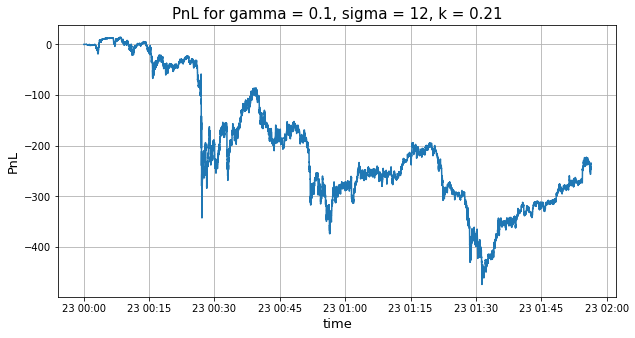

In [49]:
df = pd.read_csv('pnl.csv')
dt = pd.to_datetime(df.receive_ts)
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("PnL for gamma = 0.1, sigma = 12, k = 0.21", fontsize=15)
plt.grid()
plt.show()

Теперь $\gamma = 0.5$

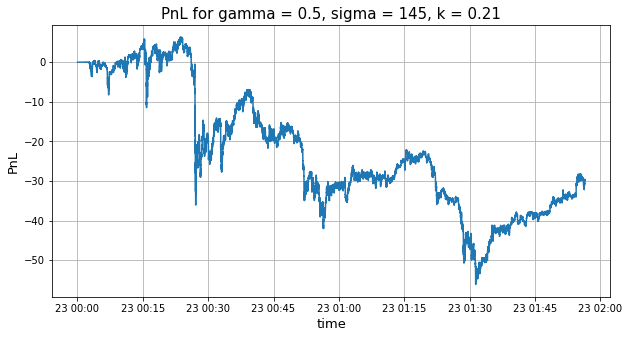

In [50]:
df = pd.read_csv('pnl.csv')
dt = pd.to_datetime(df.receive_ts)
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("PnL for gamma = 0.5, sigma = 145, k = 0.21", fontsize=15)
plt.grid()
plt.show()

Теперь $\gamma = 1$

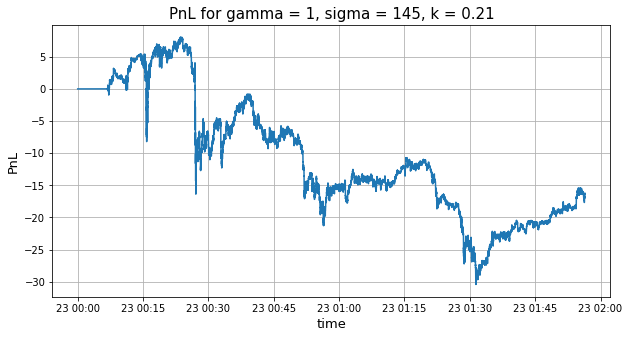

In [51]:
df = pd.read_csv('pnl.csv')
dt = pd.to_datetime(df.receive_ts)
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("PnL for gamma = 1, sigma = 145, k = 0.21", fontsize=15)
plt.grid()
plt.show()